In [173]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60
presets = 'best_quality'

do_drop_ds = True

use_groups = True
n_groups = 8

auto_stack = False
num_stack_levels = 1
num_bag_folds = 0
if auto_stack:
    num_stack_levels = None
    num_bag_folds = None

use_tune_data = True
use_tune_data_as_test = True
tune_length = 24*30*3 # 3 months from end
holdout_frac = None
use_bag_holdout = False # Enable this if there is a large gap between score_val and score_test in stack models. 

sample_weight = 'sample_weight' #None
weight_evaluation = True #False

run_analysis = False

In [174]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0].copy()
    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")

    # add sample weights, which are 1 for observed and 3 for estimated
    X_train_observed["sample_weight"] = 1
    X_train_estimated["sample_weight"] = 3
    X_test["sample_weight"] = 3

    X_train_observed["estimated_diff_hours"] = 0
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

    X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
    # the filled once will get dropped later anyways, when we drop y nans
    X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')


    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)

    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])

    # fill missng sample_weight with 3
    #X_train["sample_weight"] = X_train["sample_weight"].fillna(0)
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)

    # print number of nans in sample_weight
    print(f"Number of nans in sample_weight: {X_train['sample_weight'].isna().sum()}")
    # print number of nans in y
    print(f"Number of nans in y: {X_train['y'].isna().sum()}")


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Number of nans in sample_weight: 0
Number of nans in y: 0
Processing location B...
Number of nans in sample_weight: 0
Number of nans in y: 4
Processing location C...
Number of nans in sample_weight: 0
Number of nans in y: 6059


# Feature enginering

In [175]:
import numpy as np
import pandas as pd

X_train.dropna(subset=['y'], inplace=True)

if not do_drop_ds:
    # add hour datetime feature
    X_train["hour"] = X_train.index.hour
    X_test["hour"] = X_test.index.hour

#print(X_train.head())



if use_groups:
    # fix groups for cross validation
    locations = X_train['location'].unique()  # Assuming 'location' is the name of the column representing locations

    grouped_dfs = []  # To store data frames split by location

    # Loop through each unique location
    for loc in locations:
        loc_df = X_train[X_train['location'] == loc]
        
        # Sort the DataFrame for this location by the time column
        loc_df = loc_df.sort_index()
        
        # Calculate the size of each group for this location
        group_size = len(loc_df) // n_groups
        
        # Create a new 'group' column for this location
        loc_df['group'] = np.repeat(range(n_groups), repeats=[group_size]*(n_groups-1) + [len(loc_df) - group_size*(n_groups-1)])
        
        # Append to list of grouped DataFrames
        grouped_dfs.append(loc_df)

    # Concatenate all the grouped DataFrames back together
    X_train = pd.concat(grouped_dfs)
    X_train.sort_index(inplace=True)
    print(X_train["group"].head())





to_drop = ["snow_drift:idx", "snow_density:kgm3"]

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

ds
2019-01-01 00:00:00    0
2019-01-01 01:00:00    0
2019-01-01 02:00:00    0
2019-01-01 03:00:00    0
2019-01-01 04:00:00    0
Name: group, dtype: int64


In [176]:

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame
import numpy as np
train_data = TabularDataset('X_train_raw.csv')
# set group column of train_data be increasing from 0 to 7 based on time, the first 1/8 of the data is group 0, the second 1/8 of the data is group 1, etc.
train_data['ds'] = pd.to_datetime(train_data['ds'])
train_data = train_data.sort_values(by='ds')

# # print size of the group for each location
# for loc in locations:
#     print(f"Location {loc}:")
#     print(train_data[train_data["location"] == loc].groupby('group').size())


# get end date of train data and subtract 3 months
split_time = pd.to_datetime(train_data["ds"]).max() - pd.Timedelta(hours=tune_length)
train_set = TabularDataset(train_data[train_data["ds"] < split_time])
tune_set = TabularDataset(train_data[train_data["ds"] >= split_time])
if use_groups:
    tune_set = tune_set.drop(columns=['group'])

if do_drop_ds:
    train_set = train_set.drop(columns=['ds'])
    tune_set = tune_set.drop(columns=['ds'])
    train_data = train_data.drop(columns=['ds'])

# ensure sample weights for your training (or tuning) data sum to the number of rows in the training (or tuning) data. 
train_set["sample_weight"] = train_set["sample_weight"] / train_set["sample_weight"].sum() * len(train_set)
tune_set["sample_weight"] = tune_set["sample_weight"] / tune_set["sample_weight"].sum() * len(tune_set)
train_data["sample_weight"] = train_data["sample_weight"] / train_data["sample_weight"].sum() * len(train_data)



Loaded data from: X_train_raw.csv | Columns = 49 / 49 | Rows = 92951 -> 92951


In [177]:
if run_analysis:
    import autogluon.eda.auto as auto
    auto.dataset_overview(train_data=X_train, test_data=X_test, label="y", sample=None)

In [178]:
if run_analysis:
    auto.target_analysis(train_data=X_train, label="y")

# Starting

In [179]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 86
Now creating submission number: 87
New filename: submission_87_jorge


In [180]:
predictors = [None, None, None]

In [181]:
def fit_predictor_for_location(loc):
    print(f"Training model for location {loc}...")
    predictor = TabularPredictor(
        label=label, 
        eval_metric=metric, 
        path=f"AutogluonModels/{new_filename}_{loc}", 
        sample_weight=sample_weight, 
        weight_evaluation=weight_evaluation, 
        groups="group" if use_groups else None,
    ).fit(
        train_data= train_data[train_data["location"] == loc] if not use_tune_data else train_set[train_set["location"] == loc],
        time_limit=time_limit, 
        #presets=presets, 
        num_stack_levels=num_stack_levels, 
        num_bag_folds=num_bag_folds if not use_groups else 2,# just put somethin, will be overwritten anyways
        tuning_data=tune_set[tune_set["location"] == loc] if use_tune_data and not use_tune_data_as_test else None,
        use_bag_holdout=True if use_bag_holdout else False,
        holdout_frac=holdout_frac,
    )

    # evaluate on test data
    if use_tune_data_as_test:
        test_data = tune_set[tune_set["location"] == loc]
        perf = predictor.evaluate(test_data)
        print("Evaluation on test data:")
        print(perf[predictor.eval_metric.name])

    return predictor

loc = "A"
predictors[0] = fit_predictor_for_location(loc)



Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation will report weighted metrics, so ensure same column exists in test data.
Values in column 'group' used as split folds instead of being automatically set. Bagged models will have 8 splits.
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_87_jorge_A/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   2.25 GB / 494.38 GB (0.5%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    31900
Train Data Columns: 47
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).

Training model for location A...


AutoGluon will fit 2 stack levels (L1 to L2) ...
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ... Training model for up to 39.89s of the 59.85s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 154.57s compared to 51.84s of available time.
	Time limit exceeded... Skipping KNeighborsUnif_BAG_L1.
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 37.43s of the 57.39s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 175.28s compared to 48.64s of available time.
	Time limit exceeded... Skipping KNeighborsDist_BAG_L1.
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 34.64s of the 54.6s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-189.2687	 = Validation score   (-mean_absolute_error)
	2.0s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: LightGBM_BA

Evaluation on test data:
-204.8634300440489


In [172]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)

Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation will report weighted metrics, so ensure same column exists in test data.
Values in column 'group' used as split folds instead of being automatically set. Bagged models will have 8 splits.
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/submission_87_jorge_B/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   2.26 GB / 494.38 GB (0.5%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    30768
Train Data Columns: 47


Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 97.74541, 195.0957)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5040.68 MB
	Train Data (Original)  Memory Usage: 12.62 MB (0.3% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGener

Training model for location B...


	Useless Original Features (Count: 2): ['elevation:m', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 42 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['estimated_diff_hours']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 39 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])       :  1 | ['estimated_diff_hours']
		('int', ['bool']) :  3 | ['is_day:idx', 'is_in_shadow:idx', 'wind_speed_w_1000hPa:ms']
	0.1s = Fit runtime
	43 features in original data used to generate 43 features in processed data.
	Tr

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 loc = "B"                                                                                    │
│ ❱ 2 predictors[1] = fit_predictor_for_location(loc)                                              │
│   3                                                                                              │
│                                                                                                  │
│ in fit_predictor_for_location:3                                                                  │
│                                                                                                  │
│    1 def fit_predictor_for_location(loc):                                                        │
│    2 │   print(f"Training model for location {loc}...")                                          │
│ ❱  3 │   predictor = TabularPredictor(                                                           │
│    4 │   │   label=label,                                                                        │
│    5 │   │   eval_metric=metric,                                                                 │
│    6 │   │   path=f"AutogluonModels/{new_filename}_{loc}",                                       │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/core/utils/decorators.py: │
│ 31 in _call                                                                                      │
│                                                                                                  │
│   28 │   │   @functools.wraps(f)                                                                 │
│   29 │   │   def _call(*args, **kwargs):                                                         │
│   30 │   │   │   gargs, gkwargs = g(*other_args, *args, **kwargs)                                │
│ ❱ 31 │   │   │   return f(*gargs, **gkwargs)                                                     │
│   32 │   │                                                                                       │
│   33 │   │   return _call                                                                        │
│   34                                                                                             │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/tabular/predictor/predict │
│ or.py:986 in fit                                                                                 │
│                                                                                                  │
│    983 │   │   if fit_weighted_ensemble is False:                                                │
│    984 │   │   │   aux_kwargs["fit_weighted_ensemble"] = False                                   │
│    985 │   │   self.save(silent=True)  # Save predictor to disk to enable prediction and traini  │
│ ❱  986 │   │   self._learner.fit(                                                                │
│    987 │   │   │   X=train_data,                                                                 │
│    988 │   │   │   X_val=tuning_data,                                                            │
│    989 │   │   │   X_unlabeled=unlabeled_data,                                                   │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/tabular/learner/abstract_ │
│ learner.py:159 in fit                                      

In [ ]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)

Training model for location C...


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 loc = "C"                                                                                    │
│ ❱ 2 predictors[2] = fit_predictor_for_location(loc)                                              │
│   3                                                                                              │
│                                                                                                  │
│ in fit_predictor_for_location:3                                                                  │
│                                                                                                  │
│    1 def fit_predictor_for_location(loc):                                                        │
│    2 │   print(f"Training model for location {loc}...")                                          │
│ ❱  3 │   predictor = TabularPredictor(                                                           │
│    4 │   │   label=label,                                                                        │
│    5 │   │   eval_metric=metric,                                                                 │
│    6 │   │   path=f"AutogluonModels/{new_filename}_{loc}",                                       │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/core/utils/decorators.py: │
│ 31 in _call                                                                                      │
│                                                                                                  │
│   28 │   │   @functools.wraps(f)                                                                 │
│   29 │   │   def _call(*args, **kwargs):                                                         │
│   30 │   │   │   gargs, gkwargs = g(*other_args, *args, **kwargs)                                │
│ ❱ 31 │   │   │   return f(*gargs, **gkwargs)                                                     │
│   32 │   │                                                                                       │
│   33 │   │   return _call                                                                        │
│   34                                                                                             │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/tabular/predictor/predict │
│ or.py:927 in fit                                                                                 │
│                                                                                                  │
│    924 │   │   else:                                                                             │
│    925 │   │   │   inferred_problem_type = self._learner.infer_problem_type(y=train_data[self.l  │
│    926 │   │                                                                                     │
│ ❱  927 │   │   num_bag_folds, num_bag_sets, num_stack_levels = self._sanitize_stack_args(        │
│    928 │   │   │   num_bag_folds=num_bag_folds,                                                  │
│    929 │   │   │   num_bag_sets=num_bag_sets,                                                    │
│    930 │   │   │   num_stack_levels=num_stack_levels,                                            │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/tabular/predictor/predict │
│ or.py:3994 in _sanitize_stack_args                         

# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

Loaded data from: X_train_raw.csv | Columns = 49 / 49 | Rows = 92951 -> 92951
Loaded data from: X_test_raw.csv | Columns = 47 / 47 | Rows = 2160 -> 2160


In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:12                                                                                   │
│                                                                                                  │
│    9 │   i = location_map[loc]                                                                   │
│   10 │   subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True    │
│   11 │   #print(subset)                                                                          │
│ ❱ 12 │   pred = predictors[i].predict(subset)                                                    │
│   13 │   subset["prediction"] = pred                                                             │
│   14 │   predictions.append(subset)                                                              │
│   15                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NoneType' object has no attribute 'predict'

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│    5 │   train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax    │
│    6 │                                                                                           │
│    7 │   # plot predictions                                                                      │
│ ❱  8 │   predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")               │
│    9 │                                                                                           │
│   10 │   # title                                                                                 │
│   11 │   ax.set_title(f"Predictions for location {loc}")                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

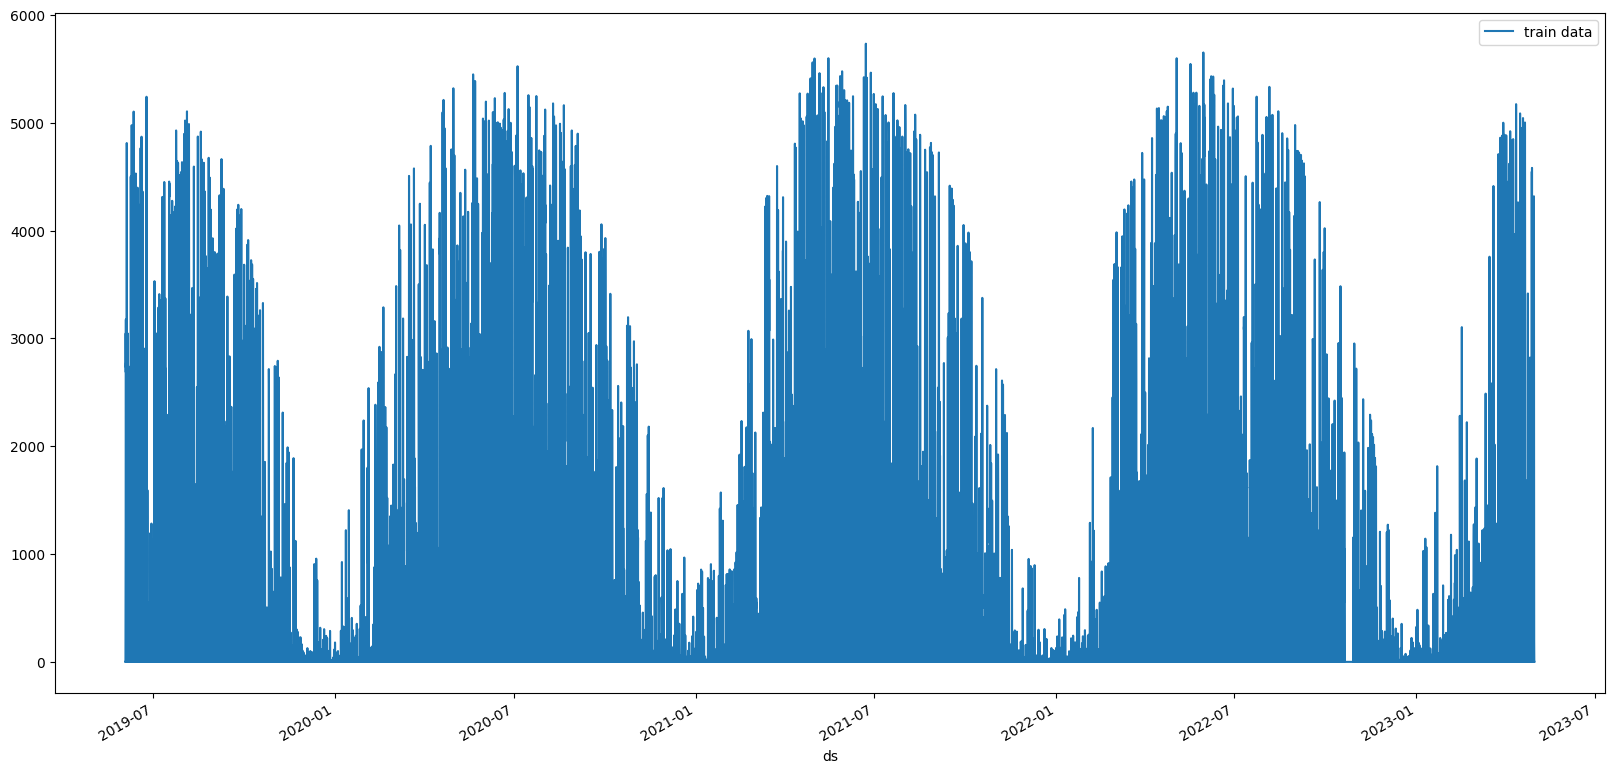

In [ ]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [ ]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # concatenate predictions                                                                    │
│ ❱ 2 submissions_df = pd.concat(predictions)                                                      │
│   3 submissions_df = submissions_df[["id", "prediction"]]                                        │
│   4 submissions_df                                                                               │
│   5                                                                                              │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/pandas/util/_decorators.py:331 in   │
│ wrapper                                                                                          │
│                                                                                                  │
│   328 │   │   │   │   │   FutureWarning,                                                         │
│   329 │   │   │   │   │   stacklevel=find_stack_level(),                                         │
│   330 │   │   │   │   )                                                                          │
│ ❱ 331 │   │   │   return func(*args, **kwargs)                                                   │
│   332 │   │                                                                                      │
│   333 │   │   # error: "Callable[[VarArg(Any), KwArg(Any)], Any]" has no                         │
│   334 │   │   # attribute "__signature__"                                                        │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/pandas/core/reshape/concat.py:368   │
│ in concat                                                                                        │
│                                                                                                  │
│   365 │   0   1   2                                                                              │
│   366 │   1   3   4                                                                              │
│   367 │   """                                                                                    │
│ ❱ 368 │   op = _Concatenator(                                                                    │
│   369 │   │   objs,                                                                              │
│   370 │   │   axis=axis,                                                                         │
│   371 │   │   ignore_index=ignore_index,                                                         │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/pandas/core/reshape/concat.py:425   │
│ in __init__                                                                                      │
│                                                                                                  │
│   422 │   │   │   objs = list(objs)                                                              │
│   423 │   │                                                                                      │
│   424 │   │   if len(objs) == 0:                                                                 │
│ ❱ 425 │   │   │   raise ValueError("No objects to concatenate")                                  │
│   426 │   │                                                                                      │
│   427 │   │   if keys is None:                             

In [ ]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)
print("jall1a")

Saving submission to submissions/submission_87_jorge.csv


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│   2                                                                                              │
│   3 # Save the submission                                                                        │
│   4 print(f"Saving submission to submissions/{new_filename}.csv")                                │
│ ❱ 5 submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)       │
│   6 print("jall1a")                                                                              │
│   7                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'submissions_df' is not defined

In [ ]:
# save this running notebook
from IPython.display import display, Javascript
import time

# hei123

display(Javascript("IPython.notebook.save_checkpoint();"))

time.sleep(3)

<IPython.core.display.Javascript object>

In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_87_jorge_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_87_jorge_files/notebook_pdfs
[NbConvertApp] Writing 126518 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 155856 bytes to notebook_pdfs/submission_87_jorge.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_87_jorge.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [ ]:
# feature importance
location="A"
split_time = pd.Timestamp("2022-10-28 22:00:00")
estimated = train_data_with_dates[train_data_with_dates["ds"] >= split_time]
estimated = estimated[estimated["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=estimated, time_limit=60*10)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3 split_time = pd.Timestamp("2022-10-28 22:00:00")                                             │
│   4 estimated = train_data_with_dates[train_data_with_dates["ds"] >= split_time]                 │
│   5 estimated = estimated[estimated["location"] == location]                                     │
│ ❱ 6 predictors[0].feature_importance(feature_stage="original", data=estimated, time_limit=60     │
│   7                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NoneType' object has no attribute 'feature_importance'

In [ ]:
# feature importance
observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]
observed = observed[observed["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=observed, time_limit=60*10)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # feature importance                                                                         │
│   2 observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]                   │
│   3 observed = observed[observed["location"] == location]                                        │
│ ❱ 4 predictors[0].feature_importance(feature_stage="original", data=observed, time_limit=60*     │
│   5                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NoneType' object has no attribute 'feature_importance'

In [ ]:
display(Javascript("IPython.notebook.save_checkpoint();"))
time.sleep(3)

subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_each_location.ipynb"])

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_87_jorge_with_feature_importance_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_87_jorge_with_feature_importance_files/notebook_pdfs
[NbConvertApp] Writing 126566 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 155857 bytes to notebook_pdfs/submission_87_jorge_with_feature_importance.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_87_jorge_with_feature_importance.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [ ]:
# import subprocess

# def execute_git_command(directory, command):
#     """Execute a Git command in the specified directory."""
#     try:
#         result = subprocess.check_output(['git', '-C', directory] + command, stderr=subprocess.STDOUT)
#         return result.decode('utf-8').strip(), True
#     except subprocess.CalledProcessError as e:
#         print(f"Git command failed with message: {e.output.decode('utf-8').strip()}")
#         return e.output.decode('utf-8').strip(), False

# git_repo_path = "."

# execute_git_command(git_repo_path, ['config', 'user.email', 'henrikskog01@gmail.com'])
# execute_git_command(git_repo_path, ['config', 'user.name', hello if hello is not None else 'Henrik eller Jørgen'])

# branch_name = new_filename

# # add datetime to branch name
# branch_name += f"_{pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# commit_msg = "run result"

# execute_git_command(git_repo_path, ['checkout', '-b',branch_name])

# # Navigate to your repo and commit changes
# execute_git_command(git_repo_path, ['add', '.'])
# execute_git_command(git_repo_path, ['commit', '-m',commit_msg])

# # Push to remote
# output, success = execute_git_command(git_repo_path, ['push', 'origin',branch_name])

# # If the push fails, try setting an upstream branch and push again
# if not success and 'upstream' in output:
#     print("Attempting to set upstream and push again...")
#     execute_git_command(git_repo_path, ['push', '--set-upstream', 'origin',branch_name])
#     execute_git_command(git_repo_path, ['push', 'origin', 'henrik_branch'])

# execute_git_command(git_repo_path, ['checkout', 'main'])